In [1]:
from primitives.primitives import *
from cirq import Circuit, LineQid, measure, sample
from scipy.linalg import expm
import matplotlib.pyplot as plt
from numpy.linalg import eig

## t-V model definition

One-dimensional spinless t-V model (range=1):

$H = -t \sum_{i=1}^{L} \left( c_i^\dagger c_{i+1} + h.c.\right) + V \sum_{i=1}^L n_i n_{i+1}$

In the 2D case we have to define horizontal and vertical hopping operators.

### Horizontal hopping operators

$H_x^{hop} (i, i+1) = i \Gamma^1_{i} \Gamma^2_{i+1} \left(\tilde \Gamma_i -\tilde\Gamma_{i+1}\right)$

In [2]:
x_hop_matrix = 1j * TensorProduct(sy_gamma_1 * sy_gamma_5, sy_gamma_2) - 1j * TensorProduct(sy_gamma_1, sy_gamma_2 * sy_gamma_5)
class HopXGate(Gate):
    """Horizontal hopping gate."""
    def _qid_shape_(self):
        return (4, 4)
    def _unitary_(self):
        return np.array(x_hop_matrix)
    def _circuit_diagram_info_(self, args):
        return ["H_x(r)", "H_x(r+1)"]
x_hop_matrix

Matrix([
[0,    0,   0, 0,   0, 0, 0,    0,   0, 0, 0,    0, 0,    0,   0, 0],
[0,    0,   0, 0,   0, 0, 0,    0,   0, 0, 0, -2.0, 0,    0,   0, 0],
[0,    0,   0, 0,   0, 0, 0,    0, 2.0, 0, 0,    0, 0,    0,   0, 0],
[0,    0,   0, 0,   0, 0, 0,    0,   0, 0, 0,    0, 0,    0,   0, 0],
[0,    0,   0, 0,   0, 0, 0,    0,   0, 0, 0,    0, 0,    0, 2.0, 0],
[0,    0,   0, 0,   0, 0, 0,    0,   0, 0, 0,    0, 0,    0,   0, 0],
[0,    0,   0, 0,   0, 0, 0,    0,   0, 0, 0,    0, 0,    0,   0, 0],
[0,    0,   0, 0,   0, 0, 0,    0,   0, 0, 0,    0, 0, -2.0,   0, 0],
[0,    0, 2.0, 0,   0, 0, 0,    0,   0, 0, 0,    0, 0,    0,   0, 0],
[0,    0,   0, 0,   0, 0, 0,    0,   0, 0, 0,    0, 0,    0,   0, 0],
[0,    0,   0, 0,   0, 0, 0,    0,   0, 0, 0,    0, 0,    0,   0, 0],
[0, -2.0,   0, 0,   0, 0, 0,    0,   0, 0, 0,    0, 0,    0,   0, 0],
[0,    0,   0, 0,   0, 0, 0,    0,   0, 0, 0,    0, 0,    0,   0, 0],
[0,    0,   0, 0,   0, 0, 0, -2.0,   0, 0, 0,    0, 0,    0,   0, 0],
[0,    0,  

### Vertical hopping operators

$H_y^{hop} (i, i+1) = i \Gamma^3_{i} \Gamma^4_{i+1} \left(\tilde \Gamma_i -\tilde\Gamma_{i+1}\right)$

In [3]:
y_hop_matrix = 1j * TensorProduct(sy_gamma_3 * sy_gamma_5, sy_gamma_4) - 1j * TensorProduct(sy_gamma_3, sy_gamma_4 * sy_gamma_5)
class HopYGate(Gate):
    """Vertical hopping gate."""
    def _qid_shape_(self):
        return (4, 4)
    def _unitary_(self):
        return np.array(y_hop_matrix)
    def _circuit_diagram_info_(self, args):
        return ["H_y(r)", "H_y(r+1)"]
y_hop_matrix

Matrix([
[0,   0,   0, 0,   0, 0, 0,   0,    0, 0, 0,    0, 0,    0,    0, 0],
[0,   0,   0, 0, 2.0, 0, 0,   0,    0, 0, 0,    0, 0,    0,    0, 0],
[0,   0,   0, 0,   0, 0, 0, 2.0,    0, 0, 0,    0, 0,    0,    0, 0],
[0,   0,   0, 0,   0, 0, 0,   0,    0, 0, 0,    0, 0,    0,    0, 0],
[0, 2.0,   0, 0,   0, 0, 0,   0,    0, 0, 0,    0, 0,    0,    0, 0],
[0,   0,   0, 0,   0, 0, 0,   0,    0, 0, 0,    0, 0,    0,    0, 0],
[0,   0,   0, 0,   0, 0, 0,   0,    0, 0, 0,    0, 0,    0,    0, 0],
[0,   0, 2.0, 0,   0, 0, 0,   0,    0, 0, 0,    0, 0,    0,    0, 0],
[0,   0,   0, 0,   0, 0, 0,   0,    0, 0, 0,    0, 0, -2.0,    0, 0],
[0,   0,   0, 0,   0, 0, 0,   0,    0, 0, 0,    0, 0,    0,    0, 0],
[0,   0,   0, 0,   0, 0, 0,   0,    0, 0, 0,    0, 0,    0,    0, 0],
[0,   0,   0, 0,   0, 0, 0,   0,    0, 0, 0,    0, 0,    0, -2.0, 0],
[0,   0,   0, 0,   0, 0, 0,   0,    0, 0, 0,    0, 0,    0,    0, 0],
[0,   0,   0, 0,   0, 0, 0,   0, -2.0, 0, 0,    0, 0,    0,    0, 0],
[0,   0,   

### Number operator

$n_i = \frac{1}{2} - \frac{1}{2}\tilde \Gamma_i$

In [4]:
number_matrix = 0.5 * sy_id - 0.5 * sy_gamma_5
class NumberGate(Gate):
    """Number gate."""
    def _qid_shape_(self):
        return (4,)
    def _unitary_(self):
        return np.array(number_matrix)
    def _circuit_diagram_info_(self, args):
        return ["n(r)"]
number_matrix

Matrix([
[0,   0,   0, 0],
[0, 1.0,   0, 0],
[0,   0, 1.0, 0],
[0,   0,   0, 0]])

### Evolution gates

In [5]:
def evolve_gate(gate):
    class evolved(Gate):
        def __init__(self, C=1, t=0.1):
            self.C = C  # coefficient
            self.t = t  # evolution time
            self.matrix = expm(np.array(-1j * self.t * self.C * gate()._unitary_(), dtype=np.complex128))
            super()
        def _qid_shape_(self):
            return gate()._qid_shape_()
        def _circuit_diagram_info_(self, args):
            return gate()._circuit_diagram_info_(args)
        def _unitary_(self):
            return self.matrix
    return evolved

# example:
evolution_hopping = evolve_gate(HopYGate)(C = 1, t = 0.5)

## Evolving a state

In [6]:
def evolve(qubits, temps, initial=None, t=1, V=0, exact=False, shots=10):

    if initial is None:
        initial = []
    
    if V != 0:
        evolution_number = evolve_gate(NumberGate)(t = temps[1]-temps[0])
        
    evolution_horizontal_hop = evolve_gate(HopXGate)(C=t, t = temps[1]-temps[0])
    evolution_vertical_hop = evolve_gate(HopYGate)(C=t, t = temps[1]-temps[0])

    results = []
    
    evolution_circuit = []
    for idx, t in enumerate(temps):

        # on site part
        if V != 0:
            for qubit in qubits.flatten():
                evolution_circuit.append(evolution_number(qubit))

        rows, columns = qubits.shape
        for r_idx, row in enumerate(qubits):
            for q_idx, qubit in enumerate(row):
                # horizontal hopping
                qubit_2 = row[0] if q_idx == columns-1 else row[q_idx+1]
                evolution_circuit.append(evolution_horizontal_hop(qubit, qubit_2))
                # vertical hopping
                qubit_2 = qubits[0][q_idx] if r_idx == rows-1 else qubits[r_idx+1][q_idx]
                evolution_circuit.append(evolution_vertical_hop(qubit, qubit_2))
                    
        if not exact:
            measures = [measure(qubit, key=f"q{idx}") for idx, qubit in enumerate(qubits.flatten())]
            if t == 0:
                circuit = Circuit([*initial, *measures])
            else:
                circuit = Circuit([*initial, *evolution_circuit, *measures])
            results.append((circuit, sample(circuit, repetitions=shots)))
            
    return results

In [7]:
def from_measurements_to_state(a):
    num_qubits = len(a.measurements)
    state_array = np.zeros(4 ** num_qubits)
    for idx in range(a.repetitions):
        state_idx = 0
        for q in a.measurements:
            q_idx = int(q[1:])
            state_idx += a.measurements[q][idx][0] * (4**(num_qubits - q_idx - 1))
        state_array[state_idx] += 1

    sum = 0
    for val in state_array:
        sum += val**2
    state_array /= np.sqrt(sum)
    
    return state_array

## Constraints

The constraint is (for every plaquette):
$\Gamma^{23}_{r}\Gamma^{23}_{r+x}\Gamma^{23}_{r+x+y}\Gamma^{23}_{r+y} \tilde\Gamma_r \tilde\Gamma_{r+x+y}= I$

We call the first operator G

In [8]:
gamma_23 = sy_gamma_2 * sy_gamma_3
G = np.array(TensorProduct(gamma_23 * sy_gamma_5, gamma_23, gamma_23, gamma_23 * sy_gamma_5), dtype=np.complex128)

single_projector = np.eye(4**4) + G
class Project_Constraint(Gate):
    """Gate that prepare an initial state, from the coefficients."""
    
    matrix = single_projector        

    def _qid_shape_(self):
        return (4, 4, 4, 4)

    def _unitary_(self):
        return self.matrix

    def _circuit_diagram_info_(self, args):
        return ["P", "P", "P", "P"]
single_projector

array([[ 1.+0.j,  0.+0.j,  0.+0.j, ...,  0.+0.j,  0.+0.j,  1.+0.j],
       [ 0.+0.j,  1.+0.j,  0.+0.j, ...,  0.+0.j, -1.+0.j,  0.+0.j],
       [ 0.+0.j,  0.+0.j,  1.+0.j, ..., -1.+0.j,  0.+0.j,  0.+0.j],
       ...,
       [ 0.+0.j,  0.+0.j, -1.+0.j, ...,  1.+0.j,  0.+0.j,  0.+0.j],
       [ 0.+0.j, -1.+0.j,  0.+0.j, ...,  0.+0.j,  1.+0.j,  0.+0.j],
       [ 1.+0.j,  0.+0.j,  0.+0.j, ...,  0.+0.j,  0.+0.j,  1.+0.j]])

## Evolving a 4x2 lattice

In [9]:
rows = 2
columns = 4

qubits = np.array(LineQid.range(rows * columns, dimension=4)).reshape(rows, columns)
temps = np.arange(0, 10, 1)
initial_circuit = None

# initial circuit that ensures that the correct subspace is used (really?)
initial_circuit = [
    Project_Constraint()(qubits[0][0], qubits[0][1], qubits[1][1], qubits[1][0]),
    Project_Constraint()(qubits[0][1], qubits[0][2], qubits[1][2], qubits[1][1]),
    Project_Constraint()(qubits[0][2], qubits[0][3], qubits[1][3], qubits[1][2]),

]

# results is a list of tuples, every tuple contains the circuit and the result shots
results = evolve(qubits, temps, initial_circuit, shots=10_000)

In [10]:
results[0][0]

┌──────────────┐   ┌──────────────┐
0 (d=4): ───P────M('q0')────────────────────────────────────────
            │
1 (d=4): ───P────P──────────────────M('q1')─────────────────────
            │    │
2 (d=4): ───┼────P──────────────────P─────────────────M('q2')───
            │    │                  │
3 (d=4): ───┼────┼──────────────────P─────────────────M('q3')───
            │    │                  │
4 (d=4): ───P────┼──────M('q4')─────┼───────────────────────────
            │    │                  │
5 (d=4): ───P────P──────────────────┼──────M('q5')──────────────
                 │                  │
6 (d=4): ────────P──────────────────P─────────────────M('q6')───
                                    │
7 (d=4): ───────────────────────────P─────────────────M('q7')───
                └──────────────┘   └──────────────┘

Text(0, 0.5, '<n>')

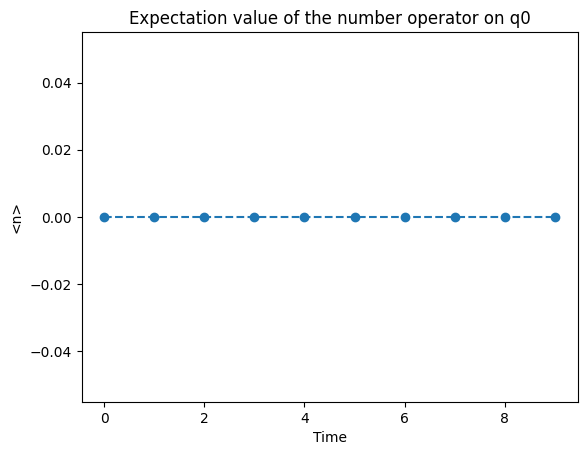

In [11]:
# Example of post-processing

result_states = [from_measurements_to_state(res[1]) for res in results]
def apply_number_op_to_q0(state):
    len_single_state = len(state)//4
    substate = state[len_single_state:len_single_state*2]
    sum_square = 0
    for el in substate:
        sum_square += el**2
    return sum_square

plt.plot(temps, [apply_number_op_to_q0(state) for state in result_states], "o--")

plt.title("Expectation value of the number operator on q0")
plt.xlabel("Time")
plt.ylabel("<n>")

In [ ]:
# Checking if the constraint hold

def increment_key(key):
    if key == "":
        return "0"*8
    idx = -1
    while True:
        if -idx > len(key):
            print("This should not be reached!")
            return key
        if int(key[idx]) < 3:
            key = list(key)
            key[idx] = str(int(key[idx])+1)
            return "".join(key)
        key = list(key)
        key[idx] = "0"
        key = "".join(key)
        idx -= 1
        
def state_to_dict(state):
    res_dict = {}
    state_key = ""
    
    for el in state:
        state_key = increment_key(state_key)
        res_dict[state_key] = el
        
    return res_dict

def extract_plaquette(state, qubits = None):
    if qubits is None:
        qubits = [0, 1, 4, 5]
    res_dict = state_to_dict(state)
    new_dict = {}
    for key in res_dict:
        temp = [key[q] for q in qubits]
        restricted_key = "".join(temp)
        if restricted_key not in new_dict:
            new_dict[restricted_key] = 0
        new_dict[restricted_key] += res_dict[key]**2

    state_array = np.array(list(new_dict.values()))
    
    sum = 0
    for val in state_array:
        sum += val**2
    state_array /= np.sqrt(sum)
    
    return state_array


plaquettes = [
    [0, 1, 4, 5],
    [1, 2, 5, 6],
    [2, 3, 6, 7]
]
evol_res = {"0": [], "1": [], "2": []}
for idx, plaquette in enumerate(plaquettes):
    for state in result_states:
        plaquette_res = extract_plaquette(state, plaquette)
        horizontal = Transpose(Matrix(plaquette_res))
        vertical = Matrix(plaquette_res)
        operator = Matrix(G)
        
        expectation_value = (horizontal * (G * vertical))[0]
        evol_res[str(idx)].append(expectation_value)

In [ ]:
for i in range(3):
    plt.plot(temps, evol_res[str(i)], "o--", label=f"plaquette {i}")
    
plt.title("Constraint Evolution")
plt.xlabel("Time")
plt.ylabel("<G>")
plt.legend()
plt.ylim(-0.5, 1.5)